**Sequence to sequence**
(使用encorder:lstm or bilstm decorder:lstm)

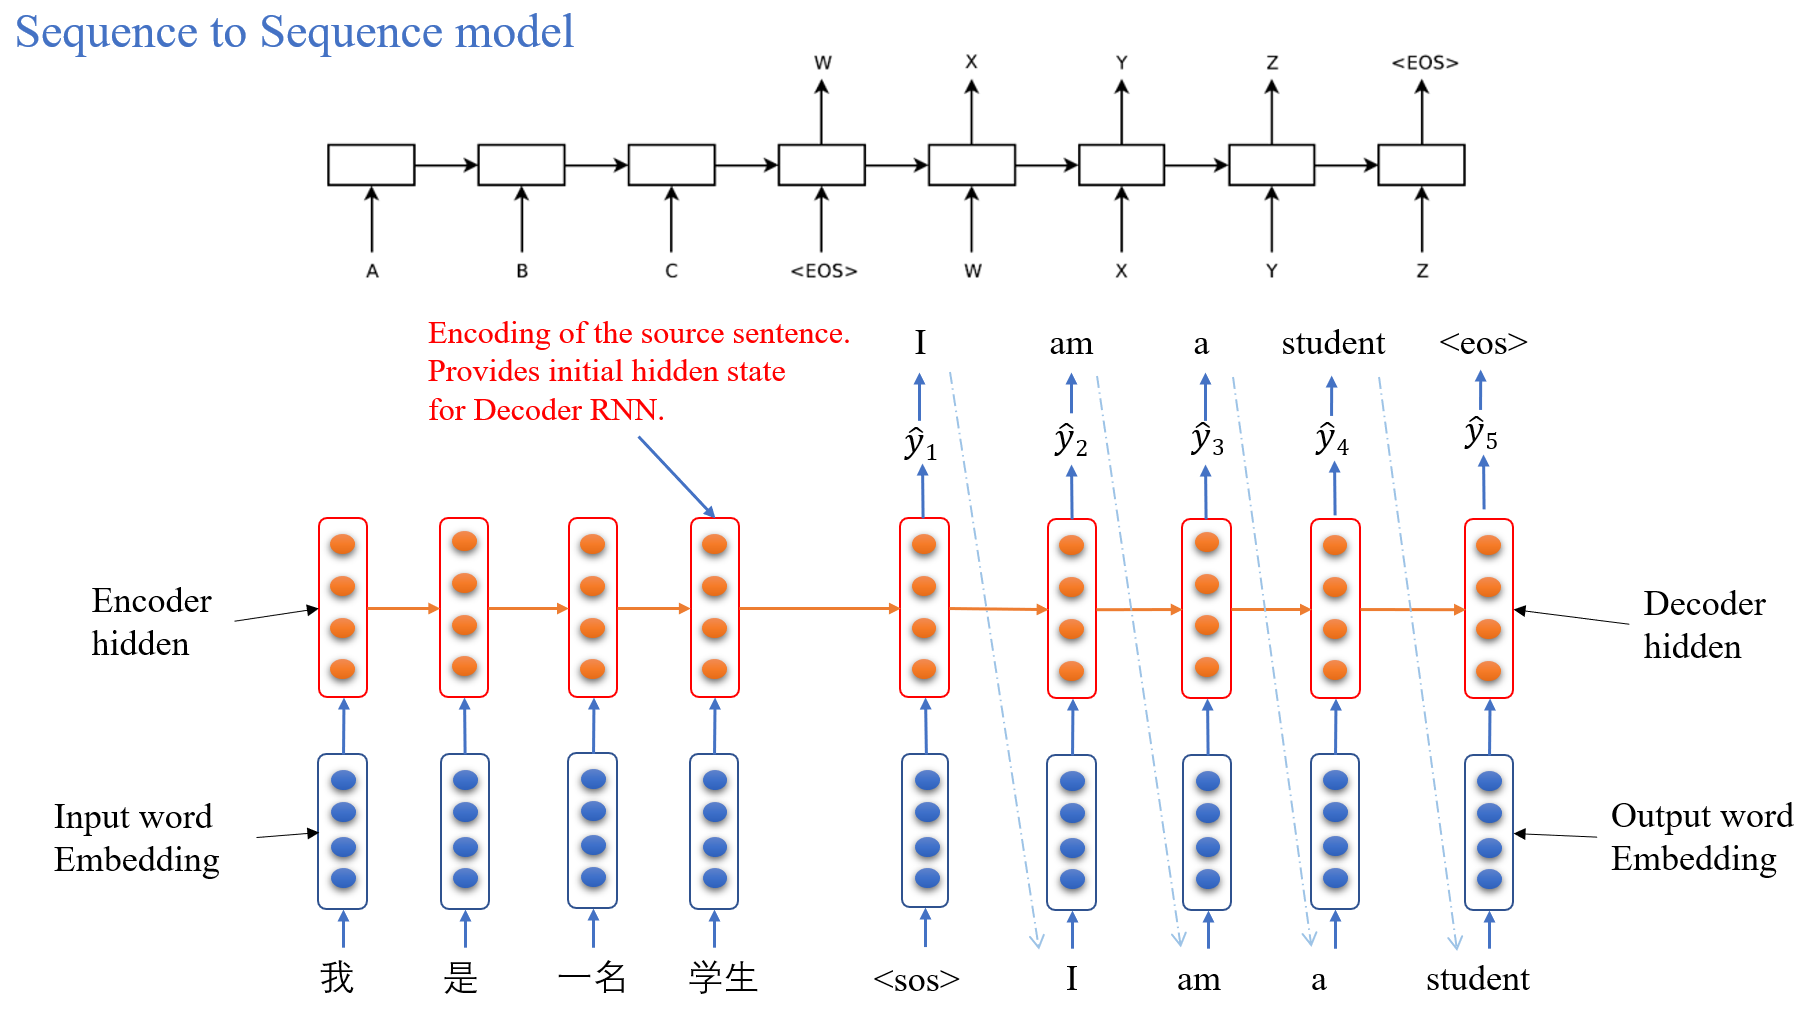

In [ ]:
import os
import gc
import time
import re
import unicodedata

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:

#Importing libraries
import tensorflow as tf
from tensorflow.keras import backend as K

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
!pip install opencc
from opencc import OpenCC
import jieba
cc = OpenCC('t2s')  #将繁体转为简体

     |████████████████████████████████| 1.3MB 6.1MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_to_file = '/content/drive/MyDrive/cmn.txt'

def preprocess_sentence_zh(w):
    w = w.lower().strip()
    w = cc.convert(w)  
    w = w.rstrip().strip()
    w = ' '.join(jieba.lcut(w))
    # 去除多余空格 
    w = re.sub(r'[" "]+', " ", w)
    return w

# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence_en(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.

  return w

In [ ]:
en_sentence = u"Please be ready in fifteen minutes."
cn_sentence = u"樂觀者在災禍中看到機會，悲觀者在機會中看到災禍。"
print(preprocess_sentence_en(en_sentence))
print(preprocess_sentence_zh(cn_sentence))

please be ready in fifteen minutes .
乐观 者 在 灾祸 中 看到 机会 ， 悲观者 在 机会 中 看到 灾祸 。


In [ ]:
# Load the dataset: sentence in english, sentence in chinese
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
TARGET_FOR_INPUT = 'target_for_input'
VOCAB_SIZE = 30000

df=pd.read_csv(path_to_file, sep="\t", header=None, names=[TARGET_COLUMN,INPUT_COLUMN], usecols=[0,1], 
               nrows=30000)
# Preprocess the input data
input_data=df[INPUT_COLUMN].apply(lambda x : preprocess_sentence_zh(x)).tolist()
# Preprocess and include the end of sentence token to the target text
target_data=df[TARGET_COLUMN].apply(lambda x : preprocess_sentence_en(x)+ ' <eos>').tolist()
# Preprocess and include a start of setence token to the input text to the decoder, it is rigth shifted
target_input_data=df[TARGET_COLUMN].apply(lambda x : '<sos> '+ preprocess_sentence_en(x)).tolist()

print(input_data[:5])
print(target_data[:5])
print(target_input_data[:5])

['嗨 。', '你好 。', '你 用 跑 的 。', '等等 ！', '等 一下 ！']
['hi . <eos>', 'hi . <eos>', 'run . <eos>', 'wait ! <eos>', 'wait ! <eos>']
['<sos> hi .', '<sos> hi .', '<sos> run .', '<sos> wait !', '<sos> wait !']


In [ ]:
#Delete the dataframe and release the memory (if it is possible)
del df
gc.collect()

22

In [ ]:
tokenizer_inputs = Tokenizer(num_words=VOCAB_SIZE, filters='')
tokenizer_inputs.fit_on_texts(input_data)
input_sequences = tokenizer_inputs.texts_to_sequences(input_data)
input_max_len = max(len(s) for s in input_sequences)
print('Max Input Length: ', input_max_len)
print(input_data[1000])
print(input_sequences[1000])

Max Input Length:  30
我 的 手臂 断 了 。
[2, 3, 1125, 3095, 4, 1]


In [ ]:
tokenizer_outputs = Tokenizer(num_words=VOCAB_SIZE, filters='')
tokenizer_outputs.fit_on_texts(target_data)
tokenizer_outputs.fit_on_texts(target_input_data)

target_sequences = tokenizer_outputs.texts_to_sequences(target_data)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_input_data)

target_max_len = max(len(s) for s in target_sequences)
print('Max Target Length: ', target_max_len)

print(target_data[1000])
print(target_sequences[1000])
print(target_input_data[1000])
print(target_sequences_inputs[1000])

Max Target Length:  37
i broke my arm . <eos>
[4, 485, 18, 808, 1, 2]
<sos> i broke my arm .
[3, 4, 485, 18, 808, 1]


In [ ]:
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1
num_words_inputs = len(word2idx_inputs) + 1
idx2word_inputs = {v:k for k,v in word2idx_inputs.items()}
idx2word_outputs = {v:k for k,v in word2idx_outputs.items()}

Found 11321 unique input tokens.
Found 6479 unique output tokens.


In [ ]:
print(word2idx_inputs)
print(idx2word_outputs)

{'。': 1, '我': 2, '的': 3, '了': 4, '你': 5, '他': 6, '？': 7, '汤姆': 8, '在': 9, '是': 10, '她': 11, '吗': 12, '我们': 13, '，': 14, '不': 15, '有': 16, '很': 17, '去': 18, '什么': 19, '这': 20, '做': 21, '没有': 22, '这个': 23, '一个': 24, '知道': 25, '都': 26, '喜欢': 27, '给': 28, '把': 29, '想': 30, '他们': 31, '说': 32, '人': 33, '会': 34, '好': 35, '?': 36, '让': 37, '要': 38, '请': 39, '和': 40, '就': 41, '对': 42, '上': 43, '来': 44, '吃': 45, '能': 46, '工作': 47, '可以': 48, '个': 49, '到': 50, '时候': 51, '没': 52, '不是': 53, '这里': 54, '它': 55, '玛丽': 56, '那': 57, '里': 58, '被': 59, '您': 60, '应该': 61, '跟': 62, '现在': 63, '告诉': 64, '得': 65, '需要': 66, '今天': 67, '事': 68, '过': 69, '看': 70, '问题': 71, '已经': 72, '认为': 73, '不要': 74, '谁': 75, '我会': 76, '从': 77, '！': 78, '自己': 79, '为': 80, '可能': 81, '明天': 82, '不会': 83, '买': 84, '很多': 85, '钱': 86, '还': 87, '东西': 88, '非常': 89, '为什么': 90, '也': 91, '哪里': 92, '比': 93, '英语': 94, '不能': 95, '必须': 96, '开始': 97, '想要': 98, '孩子': 99, '觉得': 100, '吧': 101, '怎么': 102, '昨天': 103, '再': 104, '用': 105, '那个': 106, '朋

In [ ]:
# pad the input sequences
encoder_inputs_tensor = pad_sequences(input_sequences, maxlen=input_max_len, padding='post')
print("encoder_inputs_tensor.shape:", encoder_inputs_tensor.shape)
print("encoder_inputs_tensor[0]:", encoder_inputs_tensor[0])
# pad the decoder input sequences
decoder_inputs_tensor = pad_sequences(target_sequences_inputs, maxlen=target_max_len, padding='post')
print("decoder_inputs_tensor[0]:", decoder_inputs_tensor[0])
print("decoder_inputs_tensor.shape:", decoder_inputs_tensor.shape)
# pad the target output sequences
decoder_targets_tensor = pad_sequences(target_sequences, maxlen=target_max_len, padding='post')
print('decoder_targets_tensor[0]:', decoder_targets_tensor[0])
print('decoder_targets_tensor.shape:', decoder_targets_tensor.shape)


encoder_inputs_tensor.shape: (24026, 30)
encoder_inputs_tensor[0]: [2126    1    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
decoder_inputs_tensor[0]: [   3 1701    1    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]
decoder_inputs_tensor.shape: (24026, 37)
decoder_targets_tensor[0]: [1701    1    2    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]
decoder_targets_tensor.shape: (24026, 37)


In [ ]:
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 10  # Number of epochs to train for.

# Define a dataset 
dataset = tf.data.Dataset.from_tensor_slices((encoder_inputs_tensor, decoder_inputs_tensor, decoder_targets_tensor))
print(dataset)
dataset = dataset.shuffle(len(input_data)).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<TensorSliceDataset shapes: ((30,), (37,), (37,)), types: (tf.int32, tf.int32, tf.int32)>
<BatchDataset shapes: ((64, 30), (64, 37), (64, 37)), types: (tf.int32, tf.int32, tf.int32)>


In [ ]:
#encoder为单向lstm，如果是测试seq2seq没有attention则下面的return_sequences=False
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, hidden_dim):
    super(Encoder, self).__init__()
    self.hidden_dim = hidden_dim
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(self.hidden_dim, return_sequences=False, return_state=True)
  
  def call(self, input_sequence, states):
    
    embed = self.embedding(input_sequence)
    output, state_h, state_c = self.lstm(embed, initial_state=states)

    return output, state_h, state_c

  def init_states(self, batch_size):
    return (tf.zeros([batch_size, self.hidden_dim]), tf.zeros([batch_size, self.hidden_dim]))

In [ ]:
#encoder为双向lstm
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, hidden_dim):
    super(Encoder, self).__init__()
    self.hidden_dim = hidden_dim
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True, return_state=True))
  def call(self, input_sequence, states):
    embed = self.embedding(input_sequence)
    output, forward_h, forward_c, backward_h, backward_c = self.bilstm(embed, initial_state=states)
    state_h = tf.keras.layers.concatenate([forward_h, backward_h])
    state_c = tf.keras.layers.concatenate([forward_c, backward_c])

    return output, state_h, state_c

  def init_states(self, batch_size):
    return (tf.zeros([batch_size, self.hidden_dim]), tf.zeros([batch_size, self.hidden_dim]),
            tf.zeros([batch_size, self.hidden_dim]), tf.zeros([batch_size, self.hidden_dim]))

In [ ]:
#encoder: lstm or bilstm  decoder: lstm  #若选择bilstm则hidden_dim * 2
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim 
        # Define the embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # Define the RNN layer
        self.lstm = tf.keras.layers.LSTM(
            self.hidden_dim, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, input_sequence, state):
        # Embed the input
        embed = self.embedding(input_sequence)
        # Call the LSTM unit
        lstm_out, state_h, state_c = self.lstm(embed, state)
        # Dense layer to predict output token
        logits = self.dense(lstm_out)

        return logits, state_h, state_c

In [ ]:
EMBEDDING_DIM = 128
HIDDEN_DIM=1024

#Set the length of the input and output vocabulary
num_words_inputs = len(word2idx_inputs) + 1
num_words_output = len(word2idx_outputs) + 1
encoder = Encoder(num_words_inputs, EMBEDDING_DIM, HIDDEN_DIM)
initial_state = encoder.init_states(1)
print(initial_state)
decoder = Decoder(num_words_output, EMBEDDING_DIM, HIDDEN_DIM)

(<tf.Tensor: shape=(1, 1024), dtype=float32, numpy=array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>, <tf.Tensor: shape=(1, 1024), dtype=float32, numpy=array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>)


In [ ]:
def loss_func(targets, logits):
  crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  # Mask padding values, they do not have to compute for loss
  mask = tf.math.logical_not(tf.math.equal(targets, 0))
  mask = tf.cast(mask, dtype=tf.int64)
  loss = crossentropy(targets, logits, sample_weight=mask)

  return loss

def accuracy_fn(y_true, y_pred):
    # y_pred shape is batch_size, seq length, vocab size
    # y_true shape is batch_size, seq length
    pred_values = tf.cast(tf.math.argmax(y_pred, axis=-1), dtype='int32')
    correct = tf.cast(tf.math.equal(y_true, pred_values), dtype='float32')

    # 0 is padding, don't include those
    mask = tf.cast(tf.math.greater(y_true, 0), dtype='float32')
    n_correct = tf.reduce_sum(mask * correct)
    n_total = tf.reduce_sum(mask)
    
    return n_correct / n_total

# **Teacher Forcing**
Teacher forcing is a training method critical to the development of deep learning models in NLP. It is a way for quickly and efficiently training recurrent neural network models that use the ground truth from a prior time step as input.

In a recurrent network usually the input to a RNN at the time step t is the output of the RNN in the previous time step, t-1. But with teacher forcing we can use the actual output to improve the learning capabilities of the model.

In [ ]:
# Use the @tf.function decorator to take advance of static graph computation
@tf.function
def train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):
  # Network’s computations need to be put under tf.GradientTape() to keep track of gradients
  with tf.GradientTape() as tape:
    en_outputs = encoder(input_seq, en_initial_states)
    en_states = en_outputs[1:]
    de_states = en_states

    de_outputs = decoder(target_seq_in, de_states)
    # Take the actual output
    logits = de_outputs[0]
    loss = loss_func(target_seq_out, logits)
    acc = accuracy_fn(target_seq_out, logits)
  
  variables = encoder.trainable_variables + decoder.trainable_variables
  # Calculate the gradients for the variables
  gradients = tape.gradient(loss, variables)
  # Apply the gradients and update the optimizer
  optimizer.apply_gradients(zip(gradients, variables))

  return loss, acc

In [ ]:
# Create the main train function
def main_train(encoder, decoder, dataset, n_epochs, batch_size, optimizer, checkpoint, checkpoint_prefix):
  losses = []
  accuracies = []

  for e in range(n_epochs):
    # Get the initial time
    start = time.time()
    # Get the initial state for the encoder    
    en_initial_states = encoder.init_states(batch_size)
    # For every batch data
    for batch, (input_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
      # Train and get the loss value 
      
      loss, accuracy = train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer)
      if accuracy >= 0.96:
        accuracies.append(accuracy)
        return losses, accuracies

      if batch % 100 == 0:
        losses.append(loss)
        accuracies.append(accuracy)
        print('Epoch {} Batch {} Loss {:.4f} Acc:{:.4f}'.format(e + 1, batch, loss.numpy(), accuracy.numpy()))

    # saving (checkpoint) the model every 2 epochs
    if (e+1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))

  return losses, accuracies

In [ ]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = '/content/drive/MyDrive/training_data/training_ckpt_seq2seq_lstm'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
losses, accuracies = main_train(encoder, decoder, dataset, 50, BATCH_SIZE, optimizer, checkpoint, checkpoint_prefix)


Epoch 1 Batch 0 Loss 1.9013 Acc:0.0000
Epoch 1 Batch 100 Loss 1.0976 Acc:0.2491
Epoch 1 Batch 200 Loss 1.0841 Acc:0.2898
Epoch 1 Batch 300 Loss 0.9427 Acc:0.3057
Time taken for 1 epoch 30.5192 sec

Epoch 2 Batch 0 Loss 1.0146 Acc:0.3040
Epoch 2 Batch 100 Loss 0.9711 Acc:0.3427
Epoch 2 Batch 200 Loss 0.8412 Acc:0.3301
Epoch 2 Batch 300 Loss 0.8014 Acc:0.3884
Time taken for 1 epoch 29.1388 sec

Epoch 3 Batch 0 Loss 0.7761 Acc:0.3691
Epoch 3 Batch 100 Loss 0.7713 Acc:0.3665
Epoch 3 Batch 200 Loss 0.8750 Acc:0.3717
Epoch 3 Batch 300 Loss 0.7525 Acc:0.3902
Time taken for 1 epoch 28.8055 sec

Epoch 4 Batch 0 Loss 0.8052 Acc:0.3625
Epoch 4 Batch 100 Loss 0.7536 Acc:0.3861
Epoch 4 Batch 200 Loss 0.7016 Acc:0.4135
Epoch 4 Batch 300 Loss 0.7129 Acc:0.4202
Time taken for 1 epoch 29.7999 sec

Epoch 5 Batch 0 Loss 0.6715 Acc:0.4164
Epoch 5 Batch 100 Loss 0.6822 Acc:0.4301
Epoch 5 Batch 200 Loss 0.7020 Acc:0.4357
Epoch 5 Batch 300 Loss 0.6792 Acc:0.4099
Time taken for 1 epoch 29.5128 sec

Epoch 6 Ba

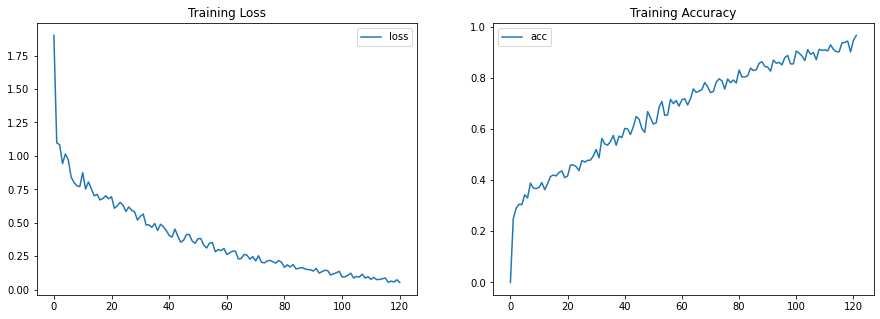

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(losses, label='loss')
ax1.set_title('Training Loss')
ax1.legend()

ax2.plot(accuracies, label='acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint_dir = '/content/drive/MyDrive/training_data/training_ckpt_seq2seq_lstm'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In the prediction step, our input is a secuence of length one, the sos token, then we call the encoder and decoder repeatedly until we get the eos token or reach the maximum length defined.

In [ ]:
# 预测function
def predict(input_text, encoder, input_max_len, tokenizer_inputs, word2idx_inputs, idx2word_outputs):
  if input_text is None:
    input_text = input_data[np.random.choice(len(input_data))]
    print(input_text)
  input_text = preprocess_sentence_zh(input_text)
  # Tokenize the input sequence
  input_seq = tokenizer_inputs.texts_to_sequences([input_text])
  # Pad the sentence
  input_seq = pad_sequences(input_seq, maxlen=input_max_len, padding='post')
  # Set the encoder initial state
  en_initial_states = encoder.init_states(1)
  en_outputs = encoder(tf.constant(input_seq), en_initial_states)
  # Create the decoder input, the sos token
  de_input = tf.constant([[word2idx_outputs['<sos>']]])
  # Set the decoder states to the encoder vector or encoder hidden state
  de_state_h, de_state_c = en_outputs[1:]  #lstm
  # de_state = en_outputs[1:] #gru

  out_words = []
  while True:
    # Decode and get the output probabilities
    de_output, de_state_h, de_state_c = decoder(de_input, (de_state_h, de_state_c))  #lstm

    # Select the word with the highest probability
    de_input = tf.argmax(de_output, -1)
    # Append the word to the predicted output
    out_words.append(idx2word_outputs[de_input.numpy()[0][0]])
    # Finish when eos token is found or the max length is reached
    if out_words[-1] == '<eos>' or len(out_words) >= 37:
      break
    
  print(' '.join(out_words))

In [ ]:
def translate(sentence):
  predict(sentence, encoder, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs)

In [ ]:
translate(u'如果明天下雨,那你就在家里吧。')
translate(u'我是一名大学生。')
translate(u'这是一个诚实的孩子。')
translate(u'星期天你打算去哪玩?')
translate(u'晚餐你想吃什么?')
translate(u'明天你记得带雨伞,可能会下雨。')
translate(u'我觉得当汤姆发现他买来的画是赝品的时候，他会很生气。')
translate(u'汤姆试过还回泳衣来换成更大一号的，但是员工告诉他那是不被允许的。')
translate(u'在十九世纪三十年代的大萧条时期，许多富人在股市崩盘中失去了一切。')

if it rains tomorrow , we ll stay at home . <eos>
i m a free man . <eos>
it s a long way to the station . <eos>
where are you planning to stay ? <eos>
what would you like for supper ? <eos>
come and see me at eleven o clock tomorrow . <eos>
i think tom will likely like his help . <eos>
tom tried to return the swimsuit for a larger size , but the clerk told him that wasn t allowed . <eos>
during the depression in the s , many wealthy people lost everything in the stock market crash . <eos>


# **Seq2seq with attention**

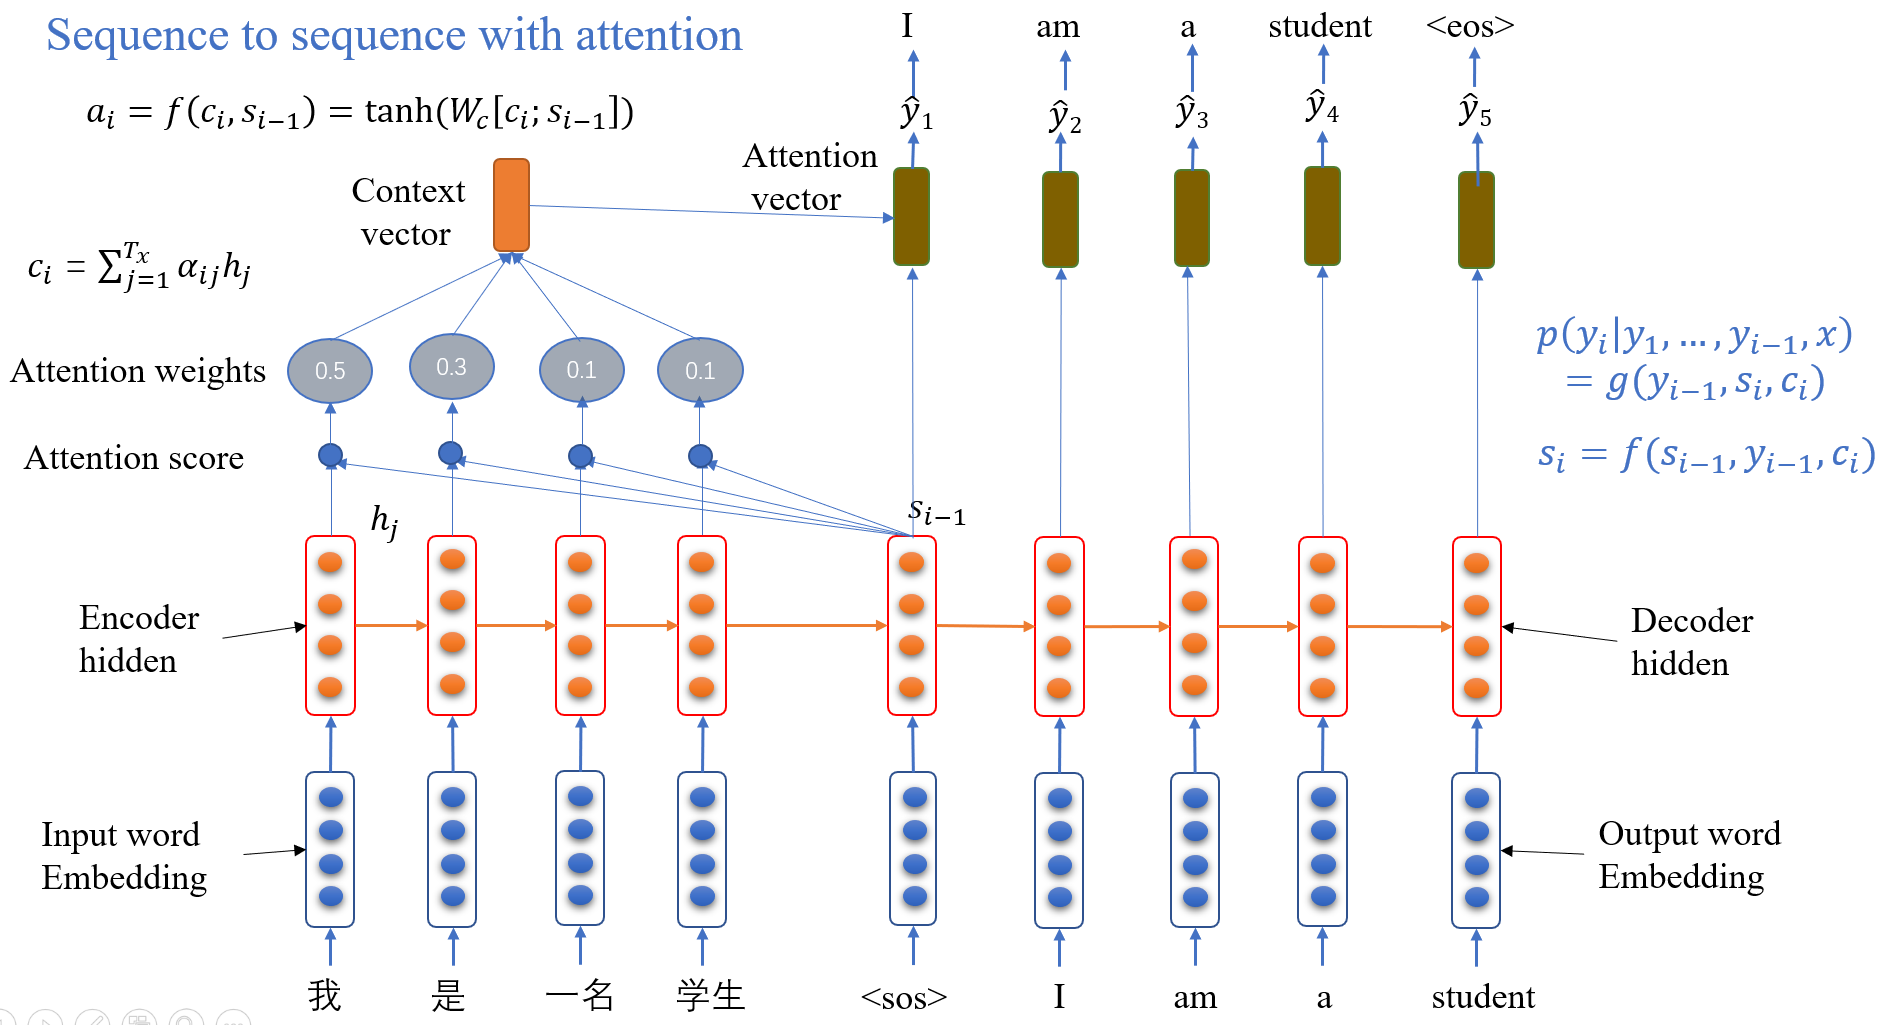

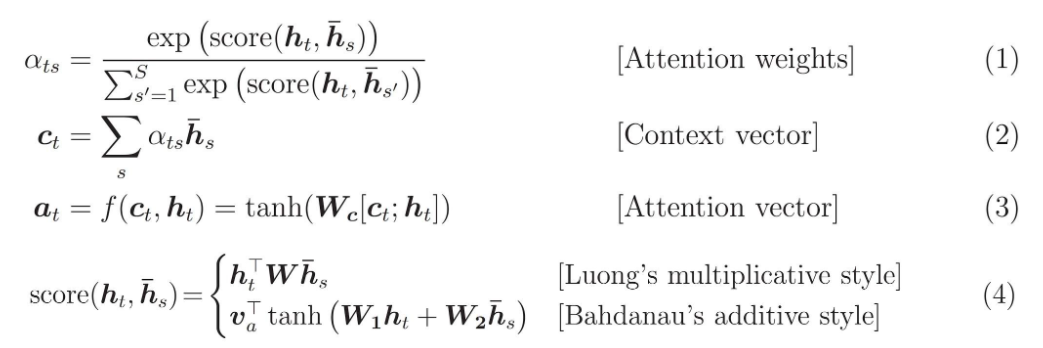

In [ ]:
#encoder为单向lstm
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, hidden_dim):
    super(Encoder, self).__init__()
    self.hidden_dim = hidden_dim
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True, return_state=True)
  
  def call(self, input_sequence, states):
    
    embed = self.embedding(input_sequence)
    output, state_h, state_c = self.lstm(embed, initial_state=states)

    return output, state_h, state_c

  def init_states(self, batch_size):
    return (tf.zeros([batch_size, self.hidden_dim]), tf.zeros([batch_size, self.hidden_dim]))

In [ ]:
#encoder为双向lstm
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, hidden_dim):
    super(Encoder, self).__init__()
    self.hidden_dim = hidden_dim
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.hidden_dim, return_sequences=True, return_state=True))
  def call(self, input_sequence, states):
    embed = self.embedding(input_sequence)
    output, forward_h, forward_c, backward_h, backward_c = self.bilstm(embed, initial_state=states)
    state_h = tf.keras.layers.concatenate([forward_h, backward_h])
    state_c = tf.keras.layers.concatenate([forward_c, backward_c])

    return output, state_h, state_c

  def init_states(self, batch_size):
    return (tf.zeros([batch_size, self.hidden_dim]), tf.zeros([batch_size, self.hidden_dim]),
            tf.zeros([batch_size, self.hidden_dim]), tf.zeros([batch_size, self.hidden_dim]))

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    # query_with_time_axis = tf.expand_dims(query, 1)
    query = tf.tile(query, [1, values.shape[1], 1])
    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(self.W1(query) + self.W2(values)))
    
    # (batch_size, max_len, 1) => (batch_size, 1, max_len)
    score = tf.transpose(score, [0, 2, 1]) #(batch_size, 1, max_len)
    # attention_weights shape == (batch_size, 1, max_length)
    attention_weights =  tf.keras.activations.softmax(score, axis=-1)

    # context_vector shape after sum == (batch_size, 1, hidden_size)
    context_vector = tf.matmul(attention_weights, values)

    return context_vector, attention_weights

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units 
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.wc = tf.keras.layers.Dense(self.dec_units, activation='tanh')
    self.ws = tf.keras.layers.Dense(vocab_size)
    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, input_sequence, state, enc_output):
    # Remember that the input to the decoder
    embed = self.embedding(input_sequence)

    lstm_output, state_h, state_c = self.lstm(embed, initial_state=state)
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(lstm_output, enc_output)
    lstm_output = tf.concat(
            [tf.squeeze(context_vector, 1), tf.squeeze(lstm_output, 1)], 1)

    att_vector = self.wc(lstm_output)
    logits = self.ws(att_vector)

    return logits, state_h, state_c, attention_weights

In [ ]:
EMBEDDING_DIM = 128
HIDDEN_DIM=1024 #512

#Set the length of the input and output vocabulary
num_words_inputs = len(word2idx_inputs) + 1
num_words_output = len(word2idx_outputs) + 1
encoder = Encoder(num_words_inputs, EMBEDDING_DIM, HIDDEN_DIM)
initial_state = encoder.init_states(1)
print(initial_state)

decoder = Decoder(num_words_output, EMBEDDING_DIM, HIDDEN_DIM)

(<tf.Tensor: shape=(1, 1024), dtype=float32, numpy=array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>, <tf.Tensor: shape=(1, 1024), dtype=float32, numpy=array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>)


In [ ]:
def loss_func(targets, logits):
  crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  # Mask padding values, they do not have to compute for loss
  mask = tf.math.logical_not(tf.math.equal(targets, 0))
  mask = tf.cast(mask, dtype=tf.int64)
  loss = crossentropy(targets, logits, sample_weight=mask)

  return loss

def accuracy_fn(y_true, y_pred):
    # y_pred shape is batch_size, seq length, vocab size
    # y_true shape is batch_size, seq length
    pred_values = tf.cast(tf.math.argmax(y_pred, axis=-1), dtype='int32')
    correct = tf.cast(tf.math.equal(y_true, pred_values), dtype='float32')

    # 0 is padding, don't include those
    mask = tf.cast(tf.math.greater(y_true, 0), dtype='float32')
    n_correct = tf.reduce_sum(mask * correct)
    n_total = tf.reduce_sum(mask)
    
    return n_correct / n_total

In [ ]:
@tf.function
def train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):
  loss = 0.
  acc = 0.
  logits = None

  with tf.GradientTape() as tape:
    en_outputs = encoder(input_seq, en_initial_states)
    en_states = en_outputs[1:]
    de_state_h, de_state_c = en_states #lstm

    for i in range(target_seq_out.shape[1]):
      decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
      logit, de_state_h, de_state_c, _ = decoder(decoder_in, (de_state_h, de_state_c), en_outputs[0]) #lstm

      loss += loss_func(target_seq_out[:, i], logit)
      logit = K.expand_dims(logit, axis=1)
      if logits is None:
        logits = logit
      else:
        logits = K.concatenate((logits, logit), axis=1)
    acc = accuracy_fn(target_seq_out, logits)

  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return loss / target_seq_out.shape[1], acc

In [ ]:
# Create the main train function
def main_train(encoder, decoder, dataset, n_epochs, batch_size, optimizer, checkpoint, checkpoint_prefix):
  losses = []
  accuracies = []

  for e in range(n_epochs):
    # Get the initial time
    start = time.time()
    # Get the initial state for the encoder    
    en_initial_states = encoder.init_states(batch_size)
    # For every batch data
    for batch, (input_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
      # Train and get the loss value 
      loss, accuracy = train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer)

      if batch % 100 == 0:
        losses.append(loss)
        accuracies.append(accuracy)
        print('Epoch {} Batch {} Loss {:.4f} Acc:{:.4f}'.format(e + 1, batch, loss.numpy(), accuracy.numpy()))

    # saving (checkpoint) the model every 2 epochs
    if (e+1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))

  return losses, accuracies

In [ ]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = '/content/drive/MyDrive/training_data/training_ckpt_seq2seq_att_lstm'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


In [ ]:
losses, accuracies = main_train(encoder, decoder, dataset, 14, BATCH_SIZE, optimizer, checkpoint, checkpoint_prefix)

Epoch 1 Batch 0 Loss 1.9792 Acc:0.0000
Epoch 1 Batch 100 Loss 1.2203 Acc:0.2477
Epoch 1 Batch 200 Loss 1.0002 Acc:0.3039
Epoch 1 Batch 300 Loss 0.9449 Acc:0.3451
Time taken for 1 epoch 546.4728 sec

Epoch 2 Batch 0 Loss 0.8504 Acc:0.3757
Epoch 2 Batch 100 Loss 0.7822 Acc:0.3927
Epoch 2 Batch 200 Loss 0.7310 Acc:0.4421
Epoch 2 Batch 300 Loss 0.7439 Acc:0.4321
Time taken for 1 epoch 508.6229 sec

Epoch 3 Batch 0 Loss 0.6042 Acc:0.4933
Epoch 3 Batch 100 Loss 0.6099 Acc:0.4991
Epoch 3 Batch 200 Loss 0.5974 Acc:0.4924
Epoch 3 Batch 300 Loss 0.6037 Acc:0.5029
Time taken for 1 epoch 505.8710 sec

Epoch 4 Batch 0 Loss 0.4479 Acc:0.5799
Epoch 4 Batch 100 Loss 0.6606 Acc:0.5083
Epoch 4 Batch 200 Loss 0.5304 Acc:0.5159
Epoch 4 Batch 300 Loss 0.4844 Acc:0.5788
Time taken for 1 epoch 509.0725 sec

Epoch 5 Batch 0 Loss 0.4225 Acc:0.6074
Epoch 5 Batch 100 Loss 0.4240 Acc:0.5974
Epoch 5 Batch 200 Loss 0.3572 Acc:0.6167
Epoch 5 Batch 300 Loss 0.4147 Acc:0.5749
Time taken for 1 epoch 506.2151 sec

Epoch

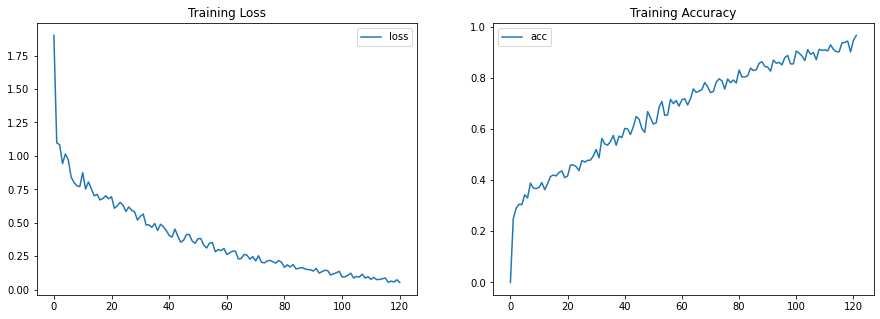

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

In [ ]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = '/content/drive/MyDrive/training_data/training_ckpt_seq2seq_att_lstm'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# matplotlib显示中文
!wget -O /usr/share/fonts/truetype/liberation/simhei.ttf "https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf"
import matplotlib.pyplot as plt
import matplotlib as mpl
zhfont = mpl.font_manager.FontProperties(fname='/usr/share/fonts/truetype/liberation/simhei.ttf')
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

--2021-01-04 02:30:47--  https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf
Resolving www.wfonts.com (www.wfonts.com)... 104.225.219.210
Connecting to www.wfonts.com (www.wfonts.com)|104.225.219.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050870 (9.6M) [application/octetstream]
Saving to: ‘/usr/share/fonts/truetype/liberation/simhei.ttf’

/usr/share/fonts/tr 100%[===================>]   9.58M  27.6MB/s    in 0.3s    

2021-01-04 02:30:48 (27.6 MB/s) - ‘/usr/share/fonts/truetype/liberation/simhei.ttf’ saved [10050870/10050870]



In [ ]:
#beam_search
import numpy as np
import tensorflow as tf
beam_length=30
def length_of_beam(beam_result, end_token):
    for i, token in enumerate(beam_result):
        if token == end_token:
            return i+1
    return len(beam_result)

def beam_step(beam_width, step, decoder, dec_input, dec_hidden, enc_outputs, 
              end_token, vocab_size, score):
  
    # First beam step
    if step == 1:
        predictions, dec_hidden_h, dec_hidden_c, attention_weights = decoder(dec_input, dec_hidden, enc_outputs)
        predictions = np.exp(predictions[0])/sum(np.exp(predictions[0]))
        predictions = tf.math.log(predictions)
        values, indices = tf.math.top_k(predictions, k=beam_width)
        dec_input_t = tf.concat([tf.broadcast_to(dec_input, [beam_width,1]), tf.expand_dims(indices,1)], axis=1)
        dec_hidden_h = tf.broadcast_to(dec_hidden_h, [beam_width,dec_hidden_h.shape[1]])
        dec_hidden_c = tf.broadcast_to(dec_hidden_c, [beam_width,dec_hidden_c.shape[1]])
        score_t = values
        dec_hidden_t = (dec_hidden_h, dec_hidden_c)

        return dec_input_t, dec_hidden_t, score_t, attention_weights
    
    beams_ended = []
    
    # Generate next set of predictions from the previous beams
    predictions, dec_hidden_h, dec_hidden_c, attention_weights = decoder(tf.expand_dims(dec_input[:,step-1],1), dec_hidden, enc_outputs)
    scores = predictions.numpy()
    scores_length_normalized = np.zeros(scores.shape)
    for b in range(beam_width):
        if dec_input[b,step-1] == end_token:
            # Beam has already reached end token
            beams_ended.append(b)
            # Set first value as the previous beam score and rest as -ve inf 
            # for all the tokens generated from the ended beam
            scores[b] = np.append([score[b]], [-np.inf] * (vocab_size-1))
        else:
            # Beam hasn't reached end token
            scores[b] = np.exp(scores[b])/sum(np.exp(scores[b]))
            scores[b] = tf.math.log(scores[b])
            scores[b] = scores[b] + score[b]
        # Length normalization of beam
        scores_length_normalized[b] = scores[b] / np.power(length_of_beam(dec_input[b],end_token), 0.7)
     
    # Initializing next set of inputs for beam step    
    dec_input_t = np.zeros([beam_width, step+1])
    dec_hidden_t = (dec_hidden_h, dec_hidden_c)
    score_t = np.zeros([beam_width])
    
    # Unrolling scores    
    scores = np.reshape(scores, (1,-1))
    scores_length_normalized = np.reshape(scores_length_normalized, (1,-1))
    values, indices = tf.math.top_k(scores_length_normalized[0], k=beam_width)
    
    for i, index in enumerate(indices):
        beam = index//vocab_size
        if beam.numpy() in beams_ended:
            # If the beam has already ended append end token
            dec_input_t[i] = np.append(dec_input[beam], [end_token])
        else:
            # If beam hasn't ended add the next token which gives higher score
            dec_input_t[i,:] = np.append(dec_input[beam,:], [index%vocab_size])
        score_t[i] = scores[0][index]
    
    return dec_input_t, dec_hidden_t, score_t, attention_weights


def beam_search(beam_width, decoder, dec_input, dec_hidden, enc_outputs, end_token, vocab_size):
    score = None
    attention_weights = []
    for t in range(1,beam_length):
        dec_input, dec_hidden, score, attention_weight = beam_step(beam_width, t, decoder, dec_input, 
                                        dec_hidden, enc_outputs, end_token, vocab_size, score)
        attention_weights.append(attention_weight.numpy())
    
    best_beam = tf.argmax(score)
    output = []
    for token in dec_input[best_beam]:
        output.append(token)
        if token == end_token:
            break
    return output, attention_weights

In [ ]:
#beam search
def predict_seq2seq_att(input_text, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs):
    if input_text is None:
        input_text = input_data[np.random.choice(len(input_data))]
    input_text = preprocess_sentence_zh(input_text)
    # Tokenize the input text
    input_seq = tokenizer_inputs.texts_to_sequences([input_text])
    # Pad the sentence
    input_seq = pad_sequences(input_seq, maxlen=input_max_len, padding='post')
    # Get the encoder initial states
    en_initial_states = encoder.init_states(1)
    # Get the encoder outputs or hidden states
    en_outputs = encoder(tf.constant(input_seq), en_initial_states)
    # Set the decoder input to the sos token
    de_input = tf.constant([[word2idx_outputs['<sos>']]])
    # Set the initial hidden states of the decoder to the hidden states of the encoder
    de_state_h, de_state_c = en_outputs[1:]
    
    beam_width = 4
    output_vocab_size = num_words_output
    # out_words = []
    output_words, attention_weights = beam_search(beam_width, decoder, de_input, (de_state_h, de_state_c), 
                         en_outputs[0], word2idx_outputs['<eos>'], output_vocab_size)
    
    return np.array(attention_weights), input_text.split(' '), output_words

# import matplotlib.ticker as ticker

def translate(sentences):

  for i, test_sent in enumerate(sentences):
      # Call the predict function to get the translation
      alignments, source, prediction = predict_seq2seq_att(test_sent, input_max_len, tokenizer_inputs, 
                                                      word2idx_outputs, idx2word_outputs)
      
      prediction = np.array(prediction,dtype=int)
      
      for i in prediction:
        print(''.join(idx2word_outputs[i]),end=' ')
      print('')

In [ ]:
#greed search
def predict_seq2seq_att(input_text, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs):
    if input_text is None:
        input_text = input_data[np.random.choice(len(input_data))]
    input_text = preprocess_sentence_zh(input_text)
    # Tokenize the input text
    input_seq = tokenizer_inputs.texts_to_sequences([input_text])
    # Pad the sentence
    input_seq = pad_sequences(input_seq, maxlen=input_max_len, padding='post')
    # Get the encoder initial states
    en_initial_states = encoder.init_states(1)
    # Get the encoder outputs or hidden states
    en_outputs = encoder(tf.constant(input_seq), en_initial_states)
    # Set the decoder input to the sos token
    de_input = tf.constant([[word2idx_outputs['<sos>']]])
    # Set the initial hidden states of the decoder to the hidden states of the encoder
    de_state_h, de_state_c = en_outputs[1:]
    
    out_words = []
    attention_weights = []

    while True:
        # Get the decoder with attention output
        de_output, de_state_h, de_state_c, attention_weight = decoder(
            de_input, (de_state_h, de_state_c), en_outputs[0])
        de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)
        # Detokenize the output
        out_words.append(idx2word_outputs[de_input.numpy()[0][0]])
        # Save the aligment matrix
        attention_weights.append(attention_weight.numpy())

        if out_words[-1] == '<eos>' or len(out_words) >= 37:
            break
    # Join the output words
    print(' '.join(out_words))
    return np.array(attention_weights), input_text.split(' '), out_words

import matplotlib.ticker as ticker

def translate(sentences):

  # Create the figure to plot in
  fig = plt.figure(figsize=(10, 20))

  for i, test_sent in enumerate(sentences):
      # Call the predict function to get the translation
      alignments, source, prediction = predict_seq2seq_att(test_sent, input_max_len, tokenizer_inputs, 
                                                      word2idx_outputs, idx2word_outputs)
      attention = np.squeeze(alignments, (1, 2))
      # Create a subplot
      ax = fig.add_subplot(1, 1, i+1)
      ax.matshow(attention[:len(prediction), :len(source)], cmap='viridis')
      ax.set_xticklabels([''] + source,  fontproperties=zhfont)
      ax.set_yticklabels([''] + prediction)
      ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
      ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  # plt.show()

if it s at home , you ll have home at home . <eos>
i m a college student . <eos>
this is an honest child . <eos>
which way do you plan to play ? <eos>
what would you like to eat ? <eos>
i ll always bring a umbrella , maybe it might rain . <eos>
i think that tom was going to be pretty mad when he finds out that the painting he bought is a fake . <eos>
tom tried to return the swimsuit for a larger size , but the clerk told him that wasn t allowed . <eos>
during the depression in the s , many wealthy people lost everything in the stock market crash . <eos>


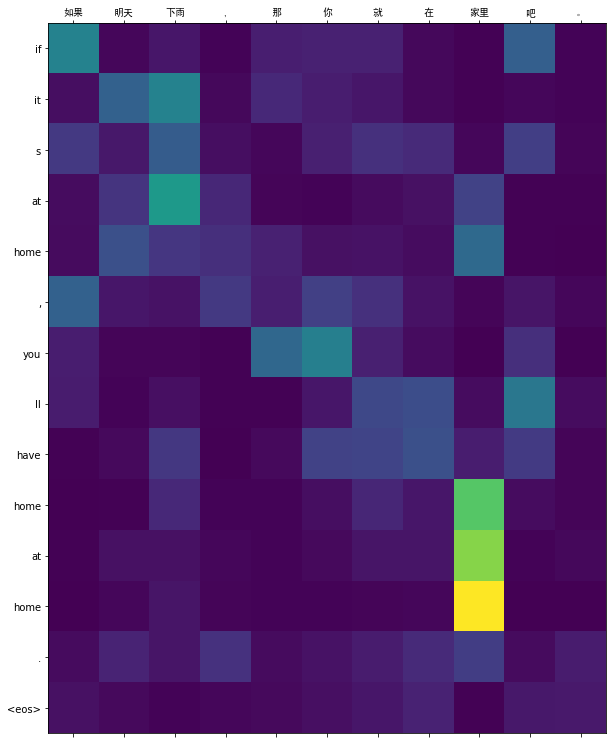

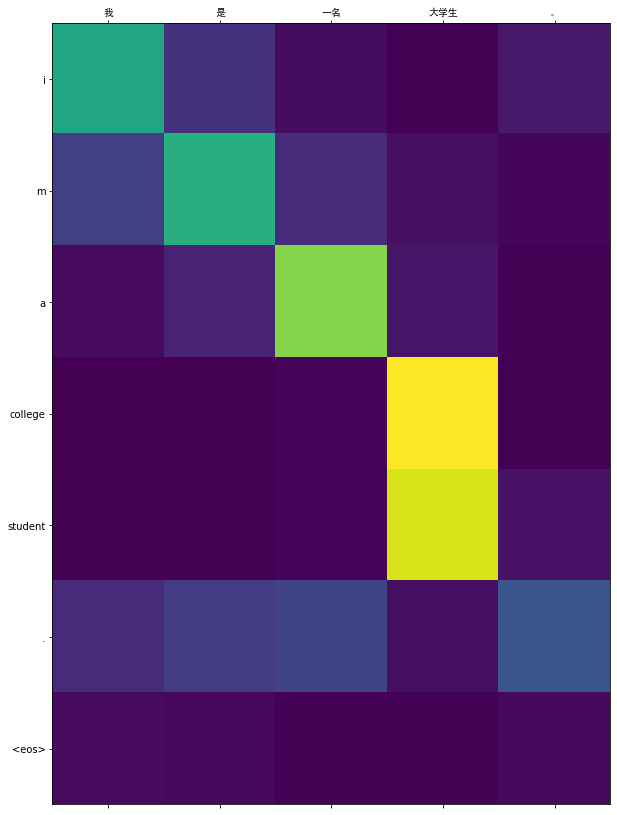

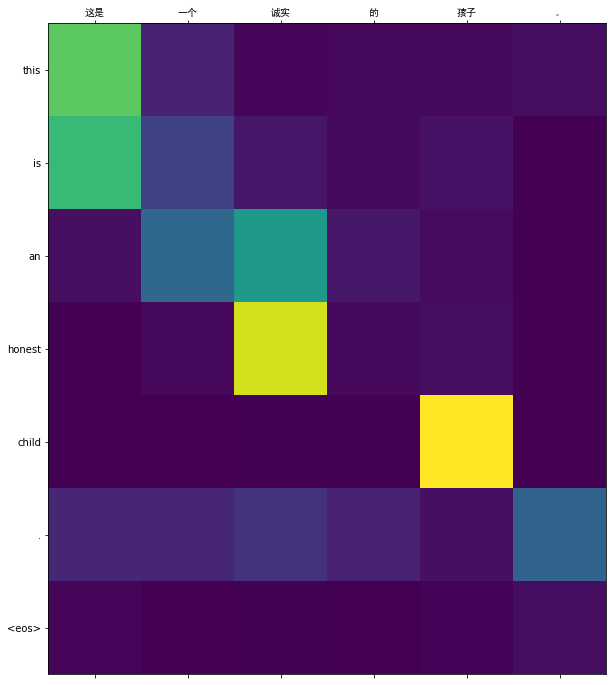

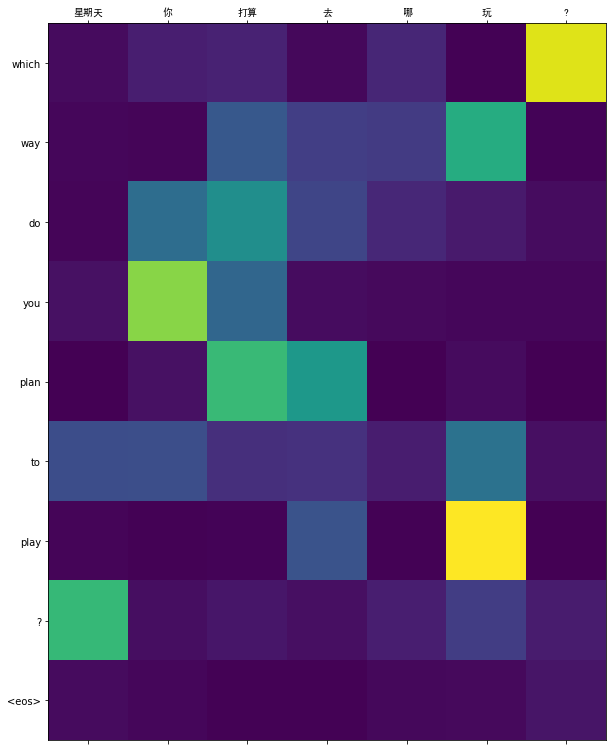

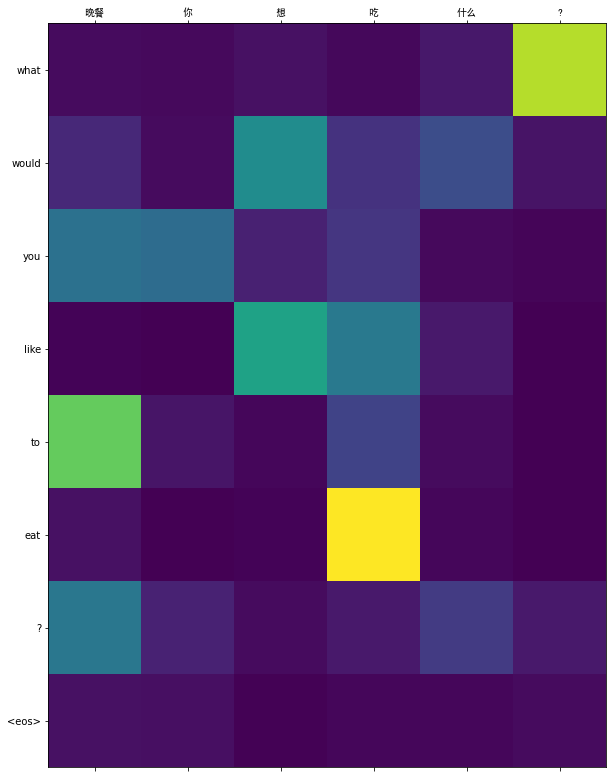

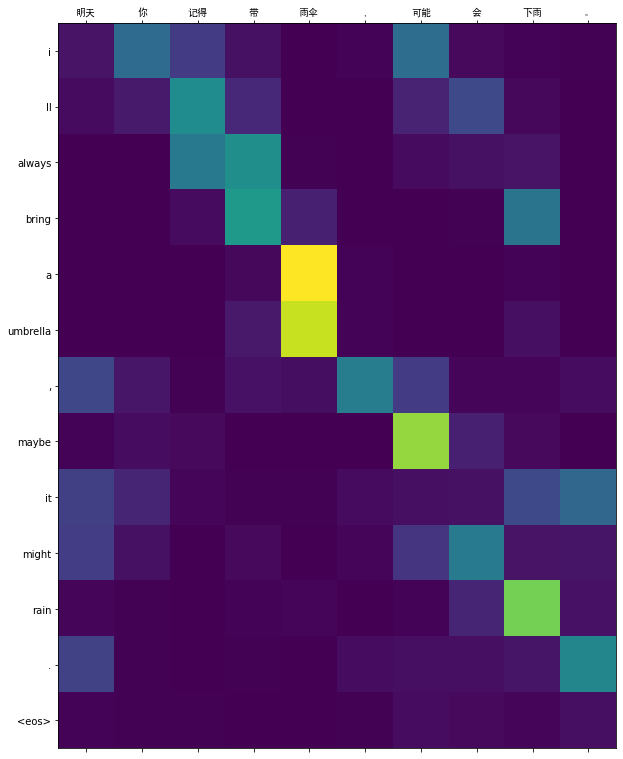

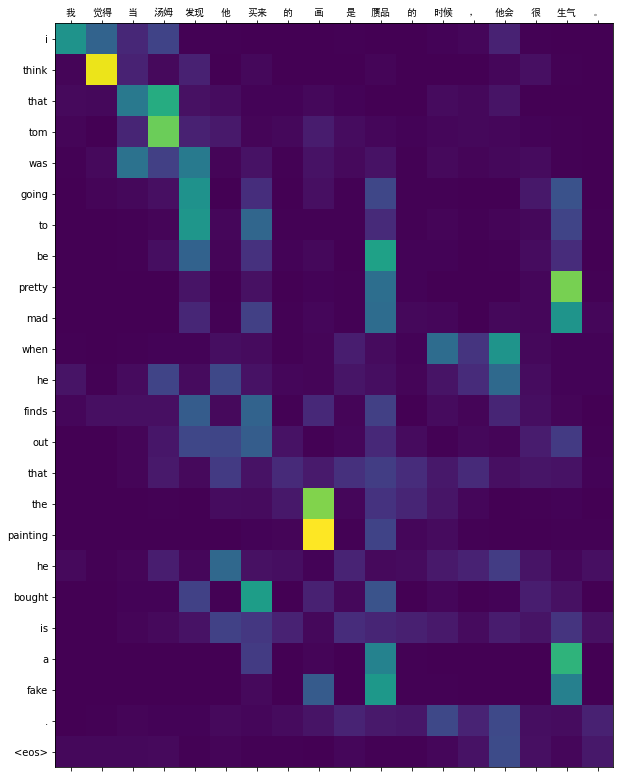

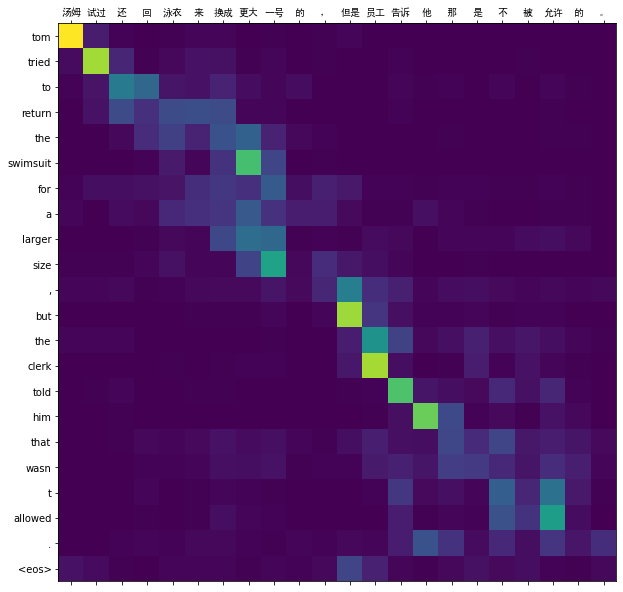

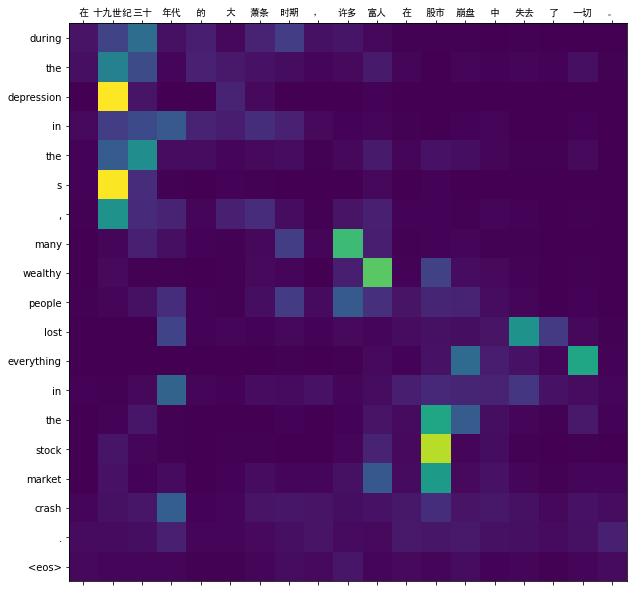

In [ ]:
translate([u'如果明天下雨,那你就在家里吧。'])
translate([u'我是一名大学生。'])
translate([u'这是一个诚实的孩子。'])
translate([u'星期天你打算去哪玩?'])
translate([u'晚餐你想吃什么?'])
translate([u'明天你记得带雨伞,可能会下雨。'])
translate([u'我觉得当汤姆发现他买来的画是赝品的时候，他会很生气。'])
translate([u'汤姆试过还回泳衣来换成更大一号的，但是员工告诉他那是不被允许的。'])
translate([u'在十九世纪三十年代的大萧条时期，许多富人在股市崩盘中失去了一切。'])